# Trying DeepLearning cluster for Microstate

In [1]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import mne

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize




# change directory go into Notebooks folder
if os.path.basename(os.getcwd()) != 'Notebooks':
    if os.path.basename(os.getcwd()) == 'lib':
        os.chdir(os.path.join(os.getcwd(), '..', 'Notebooks'))
    else:
        os.chdir(os.path.join(os.getcwd(), 'Notebooks'))
else:
    # if already in Notebooks folder, do nothing
    pass

from lib import my_functions as mf

In [2]:
id = 0

data_path = '../Data/'
folder_path = 'ica_rest_close/'
output_path = '../Output/' + folder_path
if not os.path.exists(output_path):
    os.makedirs(output_path)

id_name = f'{id:03d}'  # Format id as three digits
# id_name ='_all'
file_name = f's{id_name}.npy'

# load all data from rest_close
n_subjects = 50
all_data_close = []
for i in range(0, n_subjects):
    id_name = f'{i:03d}'  # Format id as three digits
    file_name = f's{id_name}.npy'
    data = mf.get_file_path(data_path, folder_path, file_name)
    all_data_close.append(data)

In [ ]:
id = 0

data_path = '../Data/'
folder_path = 'ica_rest_open/'
output_path = '../Output/' + folder_path
if not os.path.exists(output_path):
    os.makedirs(output_path)

id_name = f'{id:03d}'  # Format id as three digits
# id_name ='_all'
file_name = f's{id_name}.npy'

# load all data from rest_open
n_subjects = 50
all_data_open = []
for i in range(0, n_subjects):
    id_name = f'{i:03d}'  # Format id as three digits
    file_name = f's{id_name}.npy'
    data = mf.get_file_path(data_path, folder_path, file_name)
    all_data_open.append(data)

In [4]:
output_path = '../Output/ica_rest_all/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
# concatenate all data
# into one list
all_data = []
for i in range(0, n_subjects):
    data_close = all_data_close[i]
    data_open = all_data_open[i]
    data = np.concatenate((data_close, data_open), axis=0)
    all_data.append(data)


In [6]:
class EEGMicrostateNet(nn.Module):
    def __init__(self, n_channels, latent_dim, n_clusters):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels)
        )
        self.cluster_centers = nn.Parameter(torch.Tensor(n_clusters, latent_dim))
        nn.init.xavier_uniform_(self.cluster_centers.data)


    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        # Student's t-distribution for soft clustering
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q / q.sum(dim=1, keepdim=True)
        return x_hat, z, q


In [7]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def train_microstate_model(data, n_channels, latent_dim=10, n_clusters=4, epochs=50, update_interval=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = EEGMicrostateNet(n_channels, latent_dim, n_clusters).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    # Step 1: Pretrain autoencoder
    print("Pretraining autoencoder...")
    for epoch in range(10):
        x_hat, _, _ = model(data_tensor)
        loss = F.mse_loss(x_hat, data_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Pretrain Epoch {epoch}, Loss: {loss.item():.4f}')

    # Step 2: Initialize cluster centers using KMeans
    with torch.no_grad():
        _, z, _ = model(data_tensor)
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(z.cpu().numpy())
    model.cluster_centers.data.copy_(torch.tensor(kmeans.cluster_centers_, dtype=torch.float32))

    # Step 3: DEC training
    print("Training DEC...")
    for epoch in range(epochs):
        x_hat, z, q = model(data_tensor)
        if epoch % update_interval == 0:
            p = target_distribution(q.detach())
        loss_recon = F.mse_loss(x_hat, data_tensor)
        loss_kl = F.kl_div(q.log(), p, reduction='batchmean')
        loss = loss_recon + 0.1 * loss_kl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f}')
    
    # Final latent and assignments
    _, z_final, q_final = model(data_tensor)
    cluster_assignments = torch.argmax(q_final, dim=1).cpu().numpy()
    return model, z_final.cpu().detach().numpy(), cluster_assignments


In [8]:
def compute_gfp(eeg):  # shape: (n_electrodes, n_timepoints)
    return np.std(eeg, axis=0)

def evaluate_k_range(data, k_range, n_channels):
    results = []
    for k in k_range:
        print(f"\nTesting k = {k}")
        model, z_latent, labels = train_microstate_model(data, n_channels, n_clusters=k)
        score = silhouette_score(z_latent, labels)
        print(f"Silhouette Score for k={k}: {score:.4f}")
        results.append((k, score))
    return results


In [9]:
def plot_microstate_maps(model):
    with torch.no_grad():
        centroids = model.decoder(model.cluster_centers).cpu().numpy()
    for i, topo in enumerate(centroids):
        plt.plot(topo)
        plt.title(f'Microstate {i}')
        plt.xlabel('Channel')
        plt.ylabel('Activation')
        plt.show()

In [9]:
gfp_topos_all = []
best_all_k = []
k_results_all = []
max_clusters = 30  # Maximum number of clusters to evaluate
for eeg_data in all_data:
    eeg_data = eeg_data.squeeze(1)  # Remove singleton dimension if present
    n_trials, n_electrodes, n_timepoints = eeg_data.shape

    # Compute GFP and find peaks
    gfp_topos = []
    for trial in eeg_data:
        gfp = compute_gfp(trial)  # (n_timepoints,)
        peaks = np.argwhere((gfp[1:-1] > gfp[:-2]) & (gfp[1:-1] > gfp[2:])) + 1
        peak_topos = trial[:, peaks.squeeze()]  # (n_electrodes, n_peaks)
        gfp_topos.append(peak_topos.T)  # transpose to (n_peaks, n_electrodes)

    gfp_topos = np.vstack(gfp_topos)  # shape: (total_peaks, n_electrodes)
    gfp_topos = normalize(gfp_topos, norm='l2')

    k_results = evaluate_k_range(gfp_topos, k_range=range(2, max_clusters+1), n_channels=n_electrodes)

    # Choose best k and train final model
    gfp_topos_all.append(gfp_topos)
    best_k = min(k_results, key=lambda x: x[1])[0]
    best_all_k.append(best_k)
    
    k_results_all.append(k_results)
    
k_best_mean = np.mean(best_all_k)
k_best_mean = round(k_best_mean)  # Convert to integer for clarity
print(f"Mean Best K Clusters Across Subjects: {k_best_mean:.2f}")

k_best_median = np.median(best_all_k)
k_best_median = round(k_best_median)  # Convert to integer for clarity
print(f"Median Best K Clusters Across Subjects: {k_best_median:.2f}")






Testing k = 2
Pretraining autoencoder...
Pretrain Epoch 0, Loss: 0.0282
Pretrain Epoch 1, Loss: 0.0259
Pretrain Epoch 2, Loss: 0.0241
Pretrain Epoch 3, Loss: 0.0225
Pretrain Epoch 4, Loss: 0.0213
Pretrain Epoch 5, Loss: 0.0203
Pretrain Epoch 6, Loss: 0.0194
Pretrain Epoch 7, Loss: 0.0188
Pretrain Epoch 8, Loss: 0.0182
Pretrain Epoch 9, Loss: 0.0177
Training DEC...
Epoch 0, Loss: 0.0173, Recon: 0.0173, KL: 0.0001
Epoch 1, Loss: 0.0170, Recon: 0.0170, KL: 0.0000
Epoch 2, Loss: 0.0167, Recon: 0.0167, KL: 0.0000
Epoch 3, Loss: 0.0164, Recon: 0.0164, KL: 0.0000
Epoch 4, Loss: 0.0162, Recon: 0.0162, KL: 0.0000
Epoch 5, Loss: 0.0160, Recon: 0.0159, KL: 0.0002
Epoch 6, Loss: 0.0157, Recon: 0.0157, KL: 0.0002
Epoch 7, Loss: 0.0155, Recon: 0.0155, KL: 0.0001
Epoch 8, Loss: 0.0153, Recon: 0.0153, KL: 0.0001
Epoch 9, Loss: 0.0151, Recon: 0.0151, KL: 0.0001
Epoch 10, Loss: 0.0149, Recon: 0.0148, KL: 0.0005
Epoch 11, Loss: 0.0146, Recon: 0.0146, KL: 0.0004
Epoch 12, Loss: 0.0144, Recon: 0.0143, KL:

In [10]:
models_all = []
latent_all = []
labels_all = []
for gfp_topos in gfp_topos_all:

    model, latent, labels = train_microstate_model(gfp_topos, n_electrodes, n_clusters=k_best_mean)
    
    models_all.append(model)
    latent_all.append(latent)
    labels_all.append(labels)

Pretraining autoencoder...
Pretrain Epoch 0, Loss: 0.0284
Pretrain Epoch 1, Loss: 0.0261
Pretrain Epoch 2, Loss: 0.0241
Pretrain Epoch 3, Loss: 0.0225
Pretrain Epoch 4, Loss: 0.0211
Pretrain Epoch 5, Loss: 0.0200
Pretrain Epoch 6, Loss: 0.0190
Pretrain Epoch 7, Loss: 0.0183
Pretrain Epoch 8, Loss: 0.0177
Pretrain Epoch 9, Loss: 0.0172
Training DEC...
Epoch 0, Loss: 0.0168, Recon: 0.0168, KL: 0.0002
Epoch 1, Loss: 0.0165, Recon: 0.0165, KL: 0.0002
Epoch 2, Loss: 0.0162, Recon: 0.0162, KL: 0.0001
Epoch 3, Loss: 0.0159, Recon: 0.0159, KL: 0.0001
Epoch 4, Loss: 0.0157, Recon: 0.0157, KL: 0.0001
Epoch 5, Loss: 0.0156, Recon: 0.0155, KL: 0.0005
Epoch 6, Loss: 0.0154, Recon: 0.0153, KL: 0.0005
Epoch 7, Loss: 0.0152, Recon: 0.0152, KL: 0.0004
Epoch 8, Loss: 0.0150, Recon: 0.0150, KL: 0.0003
Epoch 9, Loss: 0.0148, Recon: 0.0148, KL: 0.0002
Epoch 10, Loss: 0.0148, Recon: 0.0146, KL: 0.0012
Epoch 11, Loss: 0.0146, Recon: 0.0145, KL: 0.0010
Epoch 12, Loss: 0.0144, Recon: 0.0143, KL: 0.0009
Epoch 1

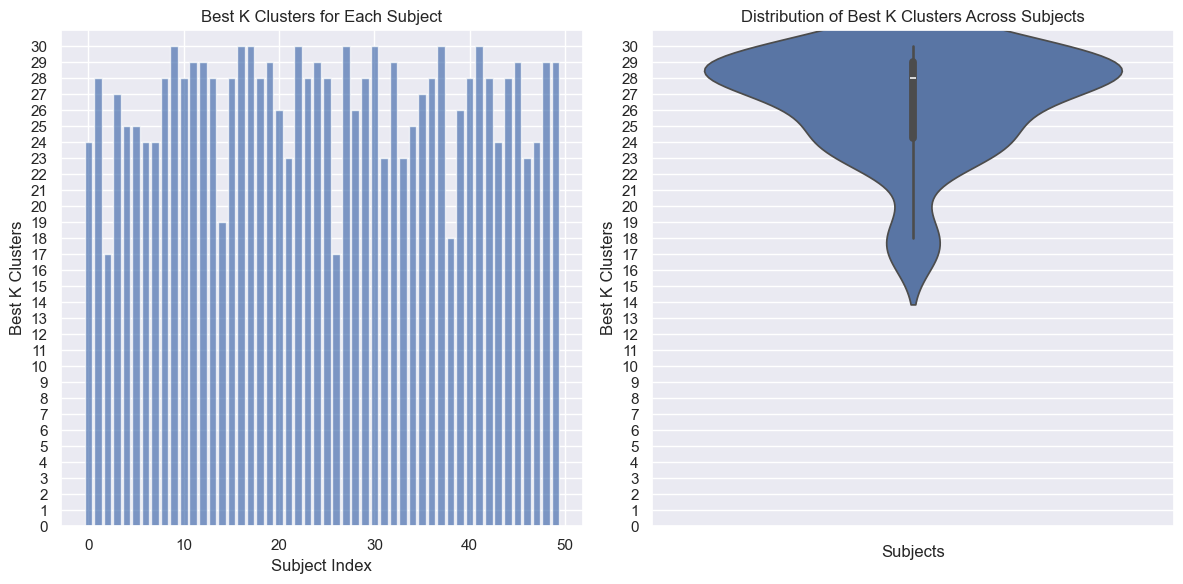

Mean Best K Clusters Across Subjects: 27.00
Median Best K Clusters Across Subjects: 28.00


In [11]:
# plot best k clusters for each subjects
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
x = np.arange(len(best_all_k))  # x-axis: subject indices
axs[0].bar(x, best_all_k, alpha=0.7)
axs[0].set_xlabel('Subject Index')
axs[0].set_ylabel('Best K Clusters')
axs[0].set_title('Best K Clusters for Each Subject')
axs[0].set_ylim(0, max_clusters+1)  # Set y-axis limit for better visibility
axs[0].set_yticks(np.arange(0, max_clusters+1, 1))  # Set y-ticks for clarity
sns.violinplot(y=best_all_k, ax=axs[1])
axs[1].set_title('Distribution of Best K Clusters Across Subjects')
axs[1].set_ylabel('Best K Clusters')
axs[1].set_xlabel('Subjects')
axs[1].set_ylim(0, max_clusters+1)  # Set y-axis limit for better visibility
axs[1].set_yticks(np.arange(0, max_clusters+1, 1))  # Set y-ticks for clarity
plt.tight_layout()
plt.show()

k_best_mean = np.mean(best_all_k)
k_best_mean = round(k_best_mean)  # Convert to integer for clarity
print(f"Mean Best K Clusters Across Subjects: {k_best_mean:.2f}")

k_best_median = np.median(best_all_k)
k_best_median = round(k_best_median)  # Convert to integer for clarity
print(f"Median Best K Clusters Across Subjects: {k_best_median:.2f}")

In [12]:
# save results
output_file = os.path.join(output_path, 'microstate_results.npy')
np.save(output_file, {
    'best_k': best_all_k,
    'models': models_all,
    'latent': latent_all,
    'labels': labels_all,
    'k_results': k_results_all,
    'gfp_topos': gfp_topos_all
})

In [33]:
output_file = os.path.join(output_path, 'microstate_results.npy')
results = np.load(output_file, allow_pickle=True).item()
best_k_all = results['best_k']
models_all = results['models']
latent_all = results['latent']
labels_all = results['labels']
k_results_all = results['k_results']
gfp_topos_all = results['gfp_topos']

In [11]:
results.keys()  # Check keys in the results dictionary

dict_keys(['best_k', 'models', 'latent', 'labels', 'k_results', 'gfp_topos'])

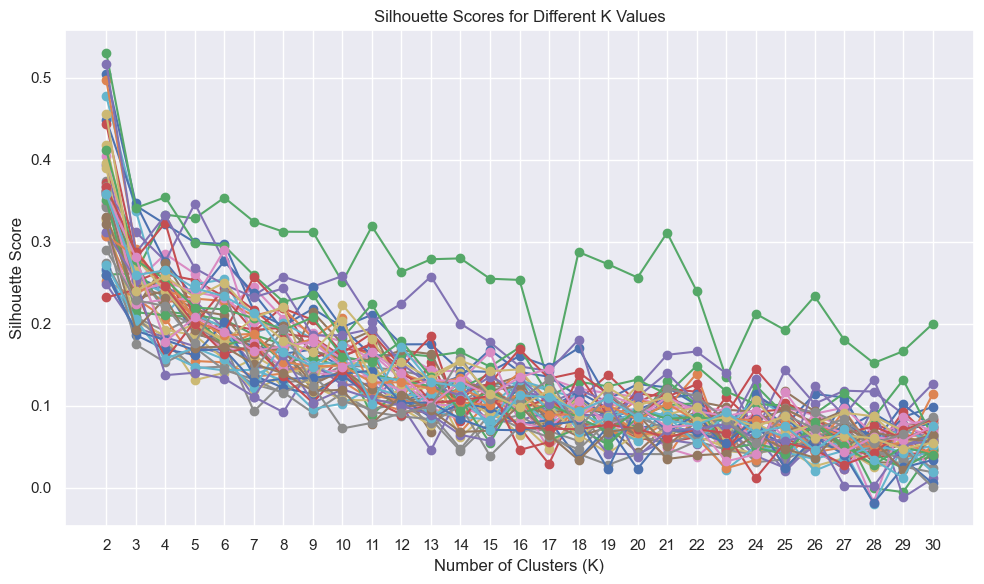

In [17]:
max_clusters = 30  # Maximum number of clusters to evaluate
plt.figure(figsize=(10, 6))
for k_results in k_results_all:
    k_values, scores = zip(*k_results)
    plt.plot(k_values, scores, marker='o')
    plt.title('Silhouette Scores for Different K Values')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(np.arange(2, max_clusters + 1, 1))
    plt.grid()
    plt.tight_layout()

    

In [15]:
# get cluster centers
with torch.no_grad():
        centroids = model.decoder(model.cluster_centers).cpu().numpy()

In [16]:
rest_ch_ls = ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3',
                'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6',
                'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5',
                'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz',
                'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2']

# Create MNE Info object
sfreq = 1000  # arbitrary sample rate
info = mne.create_info(ch_names=rest_ch_ls, sfreq=sfreq, ch_types='eeg')

# Set montage to get electrode positions
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, CP5, CP1, Pz, P3, P7, ...
 chs: 61 EEG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 1000.0 Hz
>

In [17]:
all_centroids = []
for model in models_all:
    with torch.no_grad():
        centroids = model.decoder(model.cluster_centers).cpu().numpy()
        all_centroids.append(centroids)
print(all_centroids[0].shape)


# all_centroids shape: (50, 18, 61)
# info: your MNE info object with 61 EEG channels

fig, axes = plt.subplots(nrows=50, ncols=k_best_mean, figsize=(k_best_mean * 1.1, 50))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for subj_idx, centroids in enumerate(all_centroids):         # centroids shape: (k_best_mean, 61)
    for state_idx, microstate in enumerate(centroids):       # microstate shape: (61,)
        ax = axes[subj_idx, state_idx]
        mne.viz.plot_topomap(
            microstate, info, axes=ax, show=False,
            cmap='RdBu_r', contours=0, extrapolate='local', res=100
        )
        ax.set_title(f"S{subj_idx+1}\nM{state_idx+1}", fontsize=5)
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.tight_layout()
output_file = os.path.join(output_path, 'microstates_all_subjects.png')
plt.savefig(output_file, dpi=300)
plt.close()



(27, 61)


In [18]:
# see how many repeats in all_centroids[i]

unique_counts = []

for subject in all_centroids:  # shape (27, 61)
    # Use np.unique with axis=0 to find unique topographies
    unique_microstates = np.unique(subject, axis=0)
    unique_counts.append(len(unique_microstates))

# unique_counts now contains the number of unique microstate clusters per subject
print(unique_counts)


[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]


In [40]:
def get_gmd(data_array, u_ind, v_ind):
    """
    Calculate the Global Mean Dissimilarity (GMD) between two maps for the given data array.
    
    Parameters:
    data_array (numpy.ndarray): 2D array of shape (n_channels, n_timepoints)
    gfp (numpy.ndarray): 1D array of GFP values
    u_ind (int): Index of the first map
    v_ind (int): Index of the second map
    
    Returns:
    double: GMD value
    """
    u = data_array[:, u_ind]
    v = data_array[:, v_ind]
    u_mean = np.mean(u)
    v_mean = np.mean(v)
    u_GFP = compute_gfp(u)
    v_GFP = compute_gfp(v)
    return np.sqrt(np.sum(((u - u_mean)/u_GFP - (v - v_mean)/v_GFP)**2)/data_array.shape[0])

In [41]:

centroids = all_centroids[0]  # Use the first subject's centroids
data_array = centroids.T  # Transpose to shape (n_channels, n_maps)
gmd = get_gmd(data_array, 0, 1)
print('GMD between first two channels:', gmd)
# create matrix of GMD
n_maps = data_array.shape[1]
gmd_matrix = np.zeros((n_maps, n_maps))
for i in range(n_maps):
    for j in range(n_maps):
        if i == j:
            gmd_matrix[i, j] = 0
        else:
            gmd_matrix[i, j] = get_gmd(data_array, i, j)
print('GMD matrix shape:', gmd_matrix.shape)

GMD between first two channels: 1.5256448
GMD matrix shape: (27, 27)


         0         1         2         3         4         5         6   \
0  0.000000  1.525645  1.809289  1.463428  0.197409  0.173319  1.598101   
1  1.525645  0.000000  1.179567  1.509776  1.604152  1.533483  0.520743   
2  1.809289  1.179567  0.000000  0.739364  1.854385  1.778117  0.897776   
3  1.463428  1.509776  0.739364  0.000000  1.517267  1.415506  1.269500   
4  0.197409  1.604152  1.854385  1.517267  0.000000  0.273295  1.667018   

         7         8         9   ...        17        18        19        20  \
0  0.340629  1.214008  1.793846  ...  1.735094  0.236673  0.185499  0.645021   
1  1.679652  0.555616  0.983858  ...  1.245360  1.429692  1.530621  1.789408   
2  1.760458  1.440799  0.261488  ...  0.227837  1.849188  1.866156  1.636427   
3  1.340054  1.567561  0.884865  ...  0.578676  1.582315  1.566166  1.136840   
4  0.302883  1.309617  1.850699  ...  1.783233  0.307400  0.151612  0.611589   

         21        22        23        24        25        26  
0  1

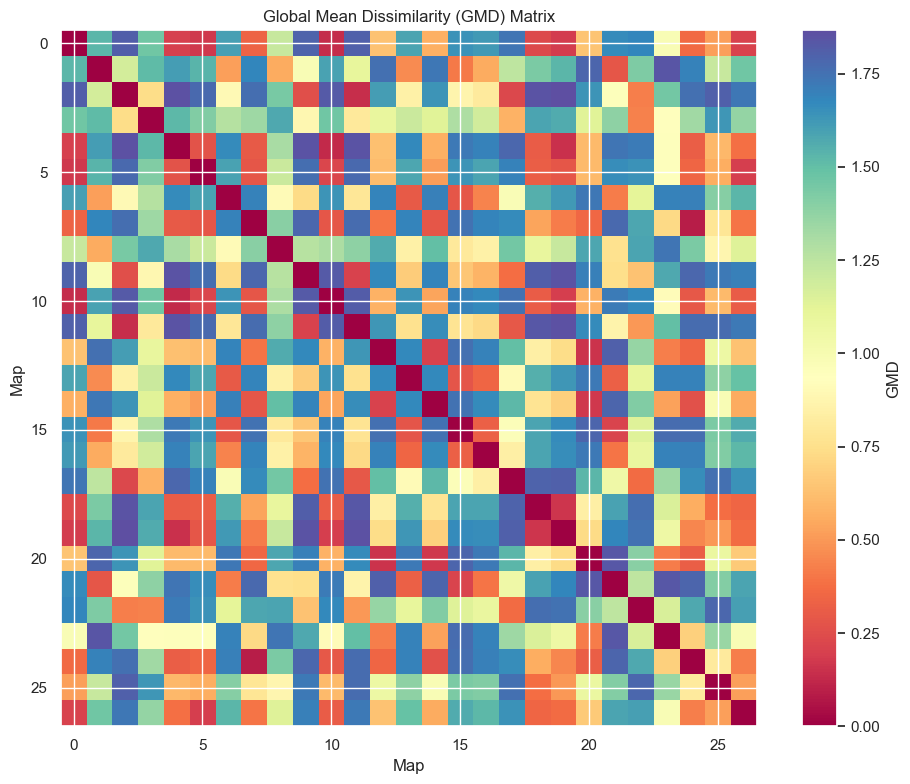

In [44]:
# label the matrix
gmd_df = pd.DataFrame(gmd_matrix)
print(gmd_df.head(5))
# # change index by 1, so 0 is 1, 1 is 2, etc.
# gmd_df.index = [f'Microstate {i+1}' for i in range(n_maps)]
# gmd_df.columns = [f'Microstate {i+1}' for i in range(n_maps)]
# plot matrix
plt.figure(figsize=(10, 8))
plt.imshow(gmd_df, cmap='Spectral', interpolation='nearest')
plt.colorbar(label='GMD')
plt.title('Global Mean Dissimilarity (GMD) Matrix')
plt.xlabel('Map')
plt.ylabel('Map')
plt.tight_layout()
plt.show()

In [24]:
print(all_centroids[0][18, :])
print(all_centroids[0][19, :])

[-0.07462966 -0.05837307 -0.00064492 -0.0062824   0.02635717 -0.01073623
 -0.01966222  0.08282633  0.03711704  0.03301064  0.07901164  0.05322566
  0.07449925  0.04237534  0.02603826  0.00959959  0.04889883  0.01256806
  0.06307714  0.02345554  0.03788118  0.03151716 -0.00388437  0.08631586
  0.01620334 -0.04149623 -0.03814901 -0.12149227 -0.03349118 -0.02410874
 -0.1170594  -0.04857585 -0.04644216 -0.0729517  -0.02466155  0.01494816
  0.00363386  0.03116916  0.03962507  0.02354027  0.06587474  0.04179642
  0.09277885  0.04881996  0.02454318  0.04903492  0.03371221  0.06829362
  0.00239064  0.02137123  0.03925125 -0.00598358  0.02907586  0.00960039
 -0.01558649  0.01657641 -0.00893211 -0.0361734  -0.06121561 -0.0194836
 -0.05754445]
[-0.09746169 -0.06047327 -0.01278531 -0.02488272  0.01917742 -0.00556898
 -0.0144117   0.08601709  0.0327112   0.04136626  0.08988806  0.06425463
  0.08670509  0.04281286  0.03123276  0.01778511  0.05106524  0.02017484
  0.06549659  0.028788    0.05034485  